In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from ray.tune.schedulers import PopulationBasedTraining
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [69]:
df=pd.read_csv('./cleaned_datasets/bike_data.csv',index_col=0)  

In [70]:
X_train = pd.read_csv('./datasets/Bikerental/X_train.csv',index_col=0)  
X_test = pd.read_csv('./datasets/Bikerental/X_test.csv',index_col=0)  
y_train = pd.read_csv('./datasets/Bikerental/y_train.csv',index_col=0)  
y_test = pd.read_csv('./datasets/Bikerental/y_test.csv',index_col=0)  

In [71]:
corr = X_train.corr()

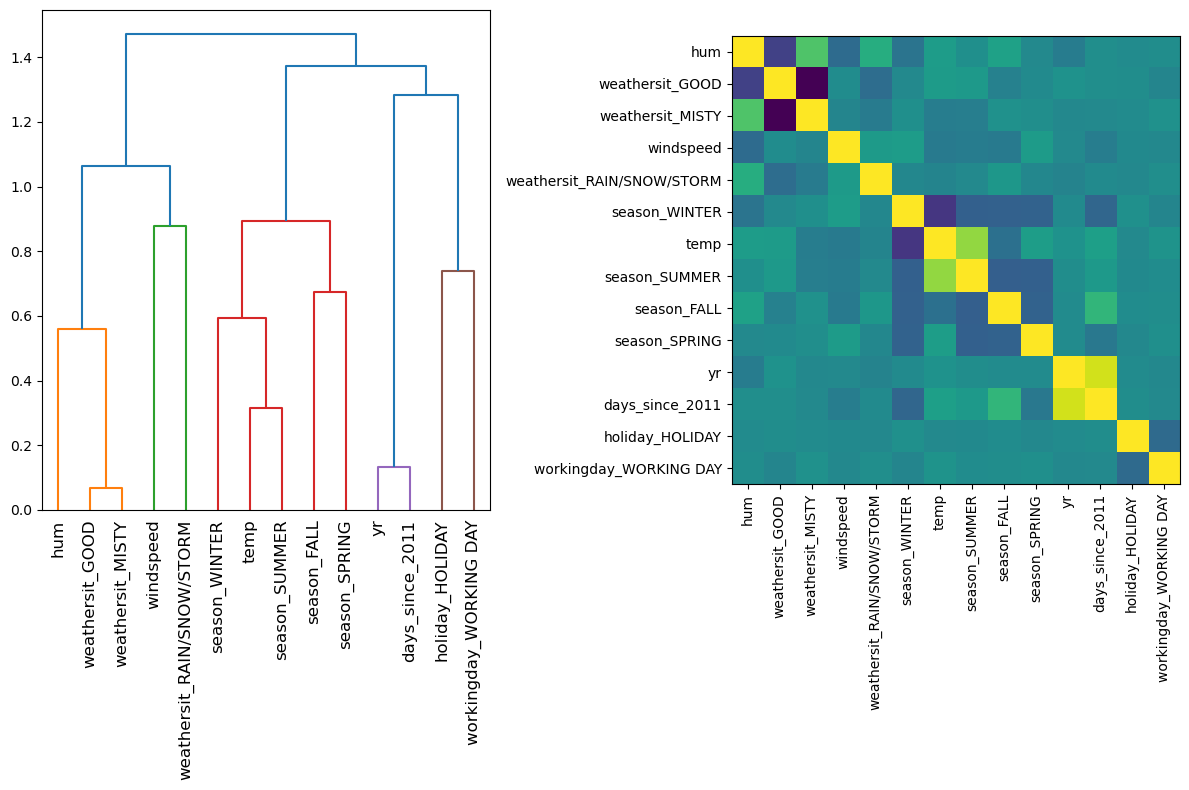

In [72]:
# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_train.columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr.iloc[dendro["leaves"], :].iloc[:, dendro["leaves"]])

ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [73]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [74]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, hidden_layers, hidden_units, dropout, dropout_array, input_dim, output_dim, activation=nn.ReLU(),norm=False):
        if hidden_layers != len(hidden_units):
            print("Error: wrong size of hidden_layers or hidden_units")
            return
        layers = []
        i = 0
        if norm:
            layers.append(nn.BatchNorm1d(input_dim))

        super(Net, self).__init__()
        
        layers.append(nn.Linear(input_dim, hidden_units[i]))
        layers.append(activation)
        if dropout:
            layers.append(nn.Dropout(dropout_array[i]))

        for _ in range(hidden_layers - 1):
            i += 1
            layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
            layers.append(activation)
            if dropout:
                layers.append(nn.Dropout(dropout_array[i]))

        layers.append(nn.Linear(hidden_units[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [75]:
net_full = torch.load('./Models/bike_rental_model')
net_full.eval()

Net(
  (net): Sequential(
    (0): Linear(in_features=14, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [76]:
from captum.attr import KernelShap

In [77]:
y_test_series = y_test.iloc[:, 0]
X_test_scaled[y_test_series.argmin()]
#y_test_series.argmax()
#y_test[y_test['Chance of Admit ']==y_test['Chance of Admit '].quantile(interpolation='nearest')].iloc[-1]
y_test_series.argmax()

12

In [78]:
X_test_scaled

array([[-0.99658119,  0.25520266,  1.82962752, ..., -1.31006835,
        -0.71074232,  5.45314974],
       [-0.99658119,  1.25959815,  0.14242348, ...,  0.76331895,
        -0.71074232, -0.18338026],
       [ 1.00343054,  0.88965203,  0.62154697, ..., -1.31006835,
         1.40697969, -0.18338026],
       ...,
       [ 1.00343054, -1.17474048, -0.66097462, ..., -1.31006835,
         1.40697969, -0.18338026],
       [ 1.00343054,  1.82136818, -1.23649915, ...,  0.76331895,
        -0.71074232, -0.18338026],
       [ 1.00343054, -0.77739094, -0.26365425, ..., -1.31006835,
         1.40697969, -0.18338026]])

[[ -554.5649     282.2277    -272.37607  ...   313.79807   -120.19357
  -1030.4025  ]
 [-1072.8733     943.37634     46.224976 ...   727.3468     185.65543
     47.904327]
 [ 1942.6149    1554.6353    -327.4796   ...  -285.87646    416.2005
    -14.449585]
 ...
 [ 2510.5073   -1798.5066     142.07397  ... -1856.358      390.3433
    186.69638 ]
 [  331.07568    341.4458     458.81415  ...  1229.5544     817.74866
   -310.21085 ]
 [ 1556.9149    -375.34726    249.18163  ...  -429.42932    629.03973
    216.52058 ]]


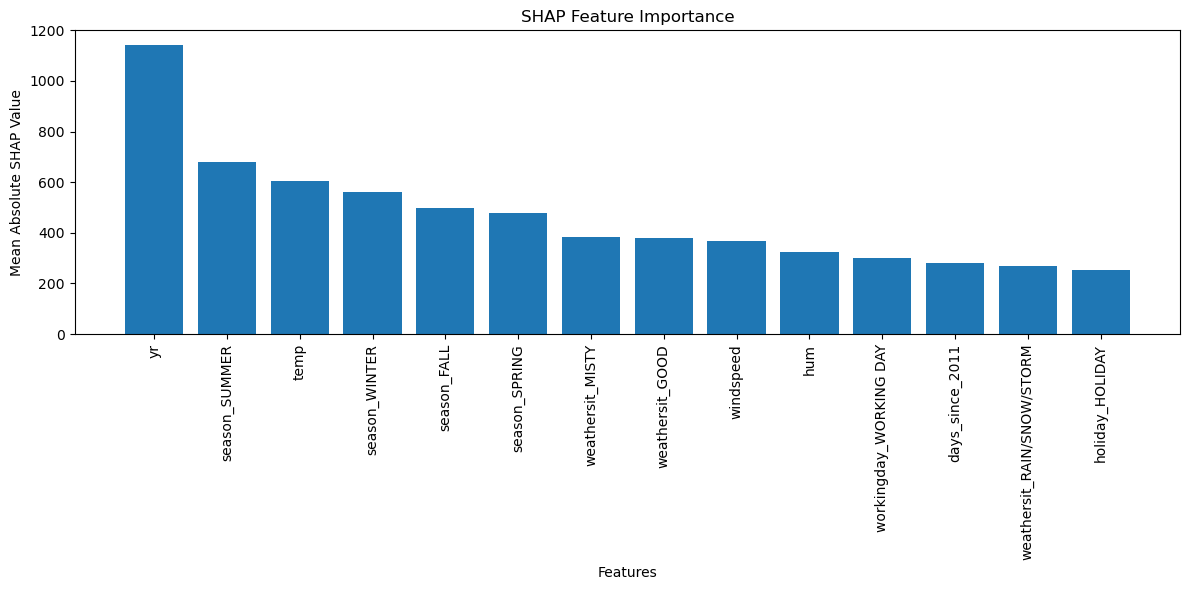

In [79]:
import torch
import numpy as np
from captum.attr import KernelShap
import matplotlib.pyplot as plt
device = next(net_full.parameters()).device
# Instantiate KernelShap
shap = KernelShap(net_full)

# Prepare your dataset
# Here, let's assume X_train is your entire dataset
# And that it's a PyTorch Tensor

X_test_t = torch.from_numpy(X_test_scaled)  # assuming X_train is numpy array
baseline = torch.tensor(X_test_scaled.mean(axis=0)).unsqueeze(0).float().to(device)
# Attribute SHAP values
global_shap_values = []

for instance in X_test_t:
    shap_values = shap.attribute(instance.unsqueeze(0).float().to(device), baseline)
    global_shap_values.append(shap_values.detach().cpu().numpy())

global_shap_values = np.array(global_shap_values)
global_shap_values = global_shap_values.reshape(-1, global_shap_values.shape[-1])
print(global_shap_values)
# Compute the mean absolute SHAP values for each feature
feature_importance = np.mean(np.abs(global_shap_values), axis=0)

# Sort features by their importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = X_test.columns[sorted_indices]

# Plot the SHAP feature importance
plt.figure(figsize=(12, 6))
plt.bar(sorted_feature_names, sorted_feature_importance)
plt.title('SHAP Feature Importance')
plt.xlabel('Features')
plt.ylabel('Mean Absolute SHAP Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


[1866.58120266 1176.0861804   786.04538283  429.86355355  383.2070817 ]


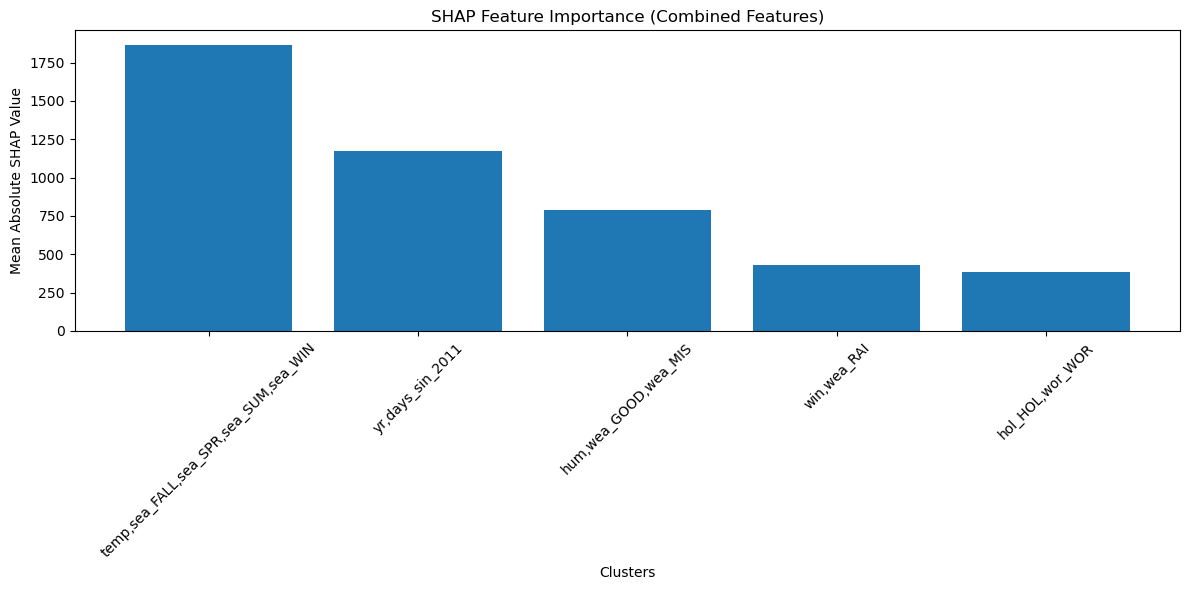

In [80]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Assume 'corr' is your correlation matrix
threshold = 1 # Set some threshold

# Compute the linkage matrix
dist_linkage = hierarchy.ward(squareform(1 - np.abs(corr)))

# Get clusters of features
clusters = hierarchy.fcluster(dist_linkage, threshold, criterion='distance')

# Compute the feature importance
global_shap_values = []

for instance in X_test_t:
    shap_values = shap.attribute(instance.unsqueeze(0).float().to(device), baseline)
    global_shap_values.append(shap_values.detach().cpu().numpy())

global_shap_values = np.array(global_shap_values)
global_shap_values = global_shap_values.reshape(-1, global_shap_values.shape[-1])

# Combine the SHAP values within each cluster
global_shap_values_combined = np.zeros((global_shap_values.shape[0], len(np.unique(clusters))))

# Store the feature names for each cluster
cluster_feature_names = {}

for i, cluster_i in enumerate(np.unique(clusters)):
    features_i = np.where(clusters == cluster_i)[0]
    global_shap_values_combined[:, i] = global_shap_values[:, features_i].sum(axis=1)

    # Map the cluster label to the feature names
    cluster_feature_names[cluster_i] = X_test.columns[features_i]

# Compute the mean absolute SHAP values for each combined feature
feature_importance_combined = np.mean(np.abs(global_shap_values_combined), axis=0)

# Sort features by their importance
sorted_indices_combined = np.argsort(feature_importance_combined)[::-1]
sorted_feature_importance_combined = feature_importance_combined[sorted_indices_combined]

# Get the feature names for the sorted clusters
sorted_feature_names_combined = [", ".join(cluster_feature_names[cluster]) for cluster in np.unique(clusters)[sorted_indices_combined]]

# Create abbreviations
abbreviations = []
for name in sorted_feature_names_combined:
    # split combined names by ','
    split_names = name.split(', ')
    # for each word, split by '_' and take first two letters of each sub-word if it's more than 4 letters
    abbrev = ','.join(['_'.join([subword[:3] if len(subword) > 4 else subword for subword in word.split('_')]) for word in split_names])
    abbreviations.append(abbrev)
print(sorted_feature_importance_combined)
# Plot the SHAP feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(abbreviations)), sorted_feature_importance_combined, tick_label=abbreviations)
plt.title('SHAP Feature Importance (Combined Features)')
plt.xlabel('Clusters')
plt.ylabel('Mean Absolute SHAP Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [81]:
X_train_with_confounder=X_train.drop(columns=['season_SPRING','season_FALL','season_SUMMER','season_WINTER'])
X_test_with_confounder=X_test.drop(columns=['season_SPRING','season_FALL','season_SUMMER','season_WINTER'])

In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled_con = scaler.fit_transform(X_train_with_confounder)
X_test_scaled_con = scaler.transform(X_test_with_confounder)

In [83]:

net = torch.load('./Models/bike_rental_model_confounder_2')
net.eval()

Net(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

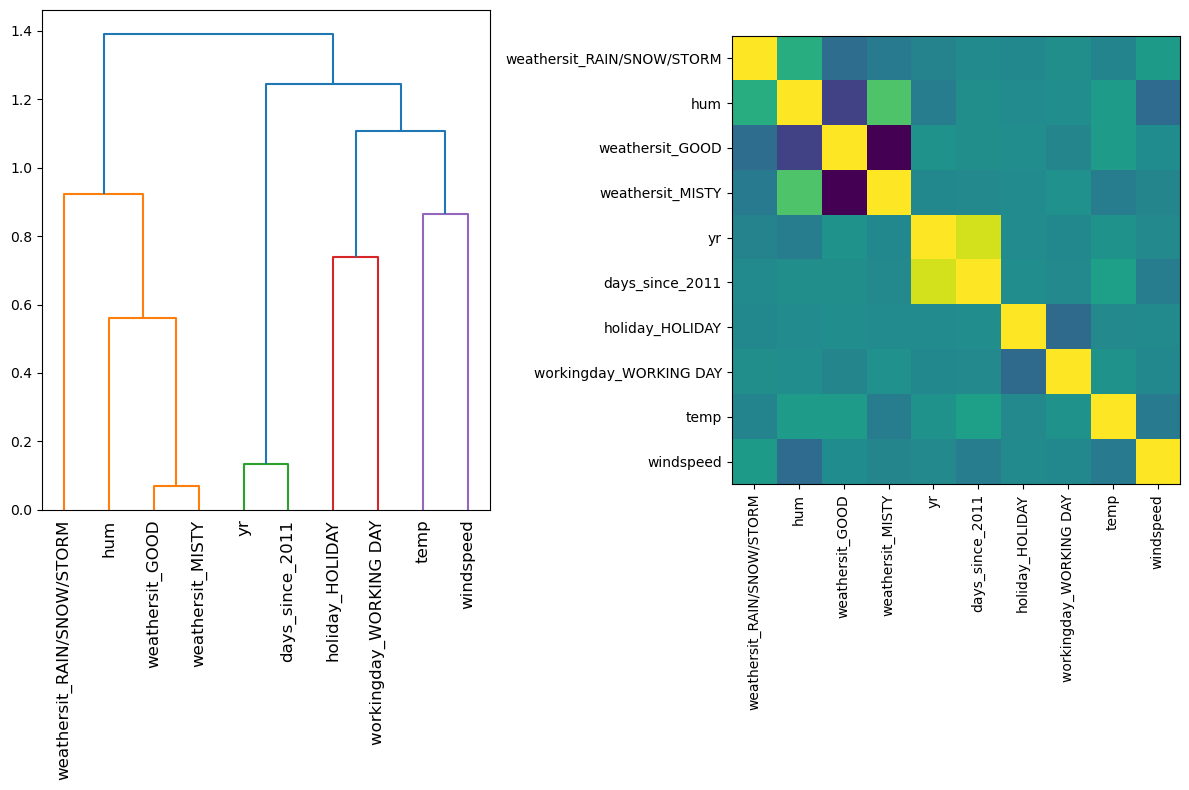

In [84]:
corr = X_train_with_confounder.corr()
# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_train_with_confounder.columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr.iloc[dendro["leaves"], :].iloc[:, dendro["leaves"]])

ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

[[ -300.74802     116.04989    -126.6955    ...  -123.790886
    127.806      -392.48624  ]
 [ -315.02023    1564.6794      -92.90967   ...   608.1769
    320.56415     103.7298   ]
 [  555.888      1197.983      -310.32294   ...  -219.39441
    605.1351      256.9732   ]
 ...
 [  449.94946   -1314.7396      126.13318   ...   164.1069
    495.83792      49.557953 ]
 [  443.7076     2111.191       321.2605    ...   383.5877
    210.51282     275.9076   ]
 [  432.83356    -790.98773     179.82419   ...  -198.52084
    521.8401       -7.8878403]]


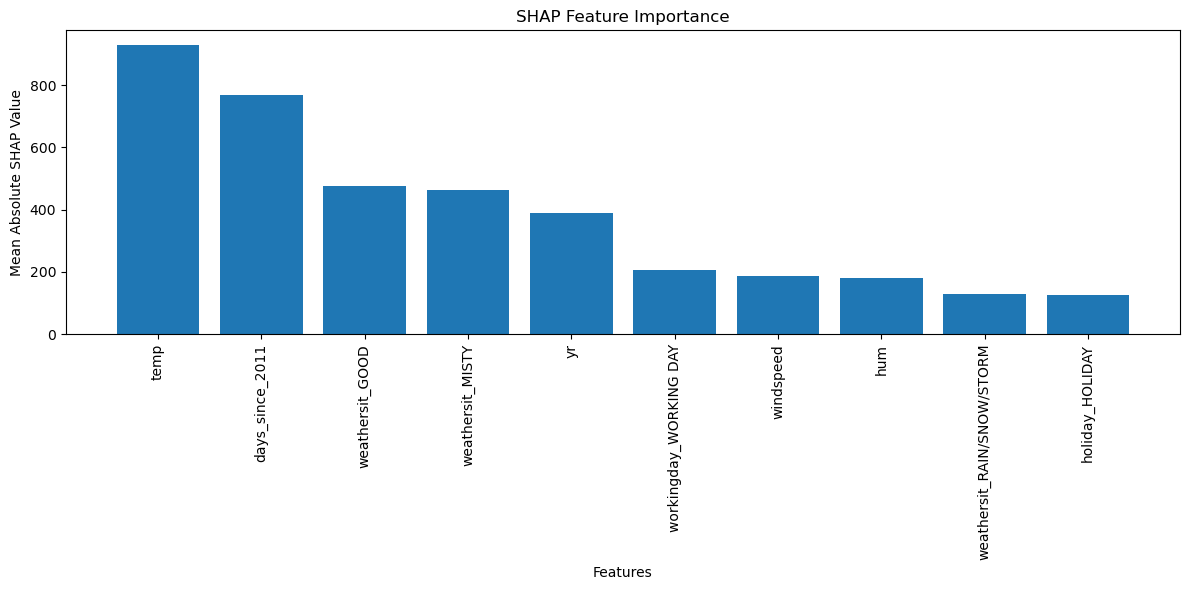

In [89]:
import torch
import numpy as np
from captum.attr import KernelShap
import matplotlib.pyplot as plt
device = next(net_full.parameters()).device
# Instantiate KernelShap
shap = KernelShap(net)

# Prepare your dataset
# Here, let's assume X_train is your entire dataset
# And that it's a PyTorch Tensor

X_test_t = torch.from_numpy(X_test_scaled_con)  # assuming X_train is numpy array
baseline = torch.tensor(X_test_scaled_con.mean(axis=0)).unsqueeze(0).float().to(device)
# Attribute SHAP values
global_shap_values = []

for instance in X_test_t:
    shap_values = shap.attribute(instance.unsqueeze(0).float().to(device), baseline)
    global_shap_values.append(shap_values.detach().cpu().numpy())

global_shap_values = np.array(global_shap_values)
global_shap_values = global_shap_values.reshape(-1, global_shap_values.shape[-1])
print(global_shap_values)
# Compute the mean absolute SHAP values for each feature
feature_importance = np.mean(np.abs(global_shap_values), axis=0)

# Sort features by their importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = X_test_with_confounder.columns[sorted_indices]

# Plot the SHAP feature importance
plt.figure(figsize=(12, 6))
plt.bar(sorted_feature_names, sorted_feature_importance)
plt.title('SHAP Feature Importance')
plt.xlabel('Features')
plt.ylabel('Mean Absolute SHAP Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


[1146.52230596  947.54539736  889.2979469   307.94697869  202.61133517
  133.82314825]


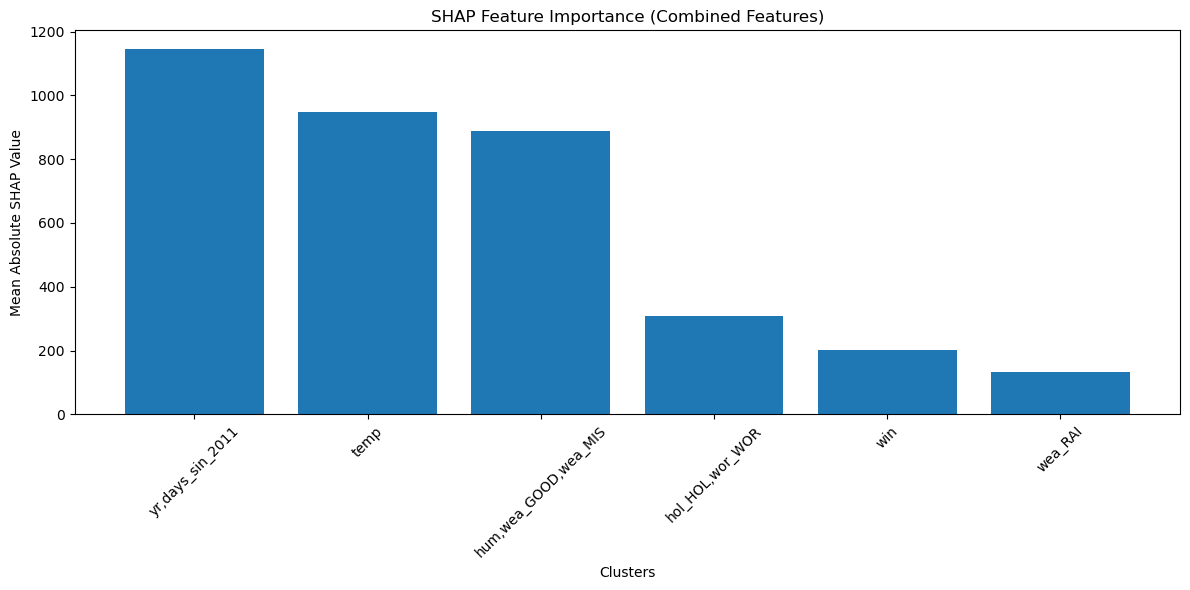

In [90]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Assume 'corr' is your correlation matrix
threshold = 0.8  # Set some threshold

# Compute the linkage matrix
dist_linkage = hierarchy.ward(squareform(1 - np.abs(corr)))

# Get clusters of features
clusters = hierarchy.fcluster(dist_linkage, threshold, criterion='distance')

# Compute the feature importance
global_shap_values = []

for instance in X_test_t:
    shap_values = shap.attribute(instance.unsqueeze(0).float().to(device), baseline)
    global_shap_values.append(shap_values.detach().cpu().numpy())

global_shap_values = np.array(global_shap_values)
global_shap_values = global_shap_values.reshape(-1, global_shap_values.shape[-1])

# Combine the SHAP values within each cluster
global_shap_values_combined = np.zeros((global_shap_values.shape[0], len(np.unique(clusters))))

# Store the feature names for each cluster
cluster_feature_names = {}

for i, cluster_i in enumerate(np.unique(clusters)):
    features_i = np.where(clusters == cluster_i)[0]
    global_shap_values_combined[:, i] = global_shap_values[:, features_i].sum(axis=1)

    # Map the cluster label to the feature names
    cluster_feature_names[cluster_i] = X_test_with_confounder.columns[features_i]

# Compute the mean absolute SHAP values for each combined feature
feature_importance_combined = np.mean(np.abs(global_shap_values_combined), axis=0)

# Sort features by their importance
sorted_indices_combined = np.argsort(feature_importance_combined)[::-1]
sorted_feature_importance_combined = feature_importance_combined[sorted_indices_combined]

# Get the feature names for the sorted clusters
sorted_feature_names_combined = [", ".join(cluster_feature_names[cluster]) for cluster in np.unique(clusters)[sorted_indices_combined]]

# Create abbreviations
abbreviations = []
for name in sorted_feature_names_combined:
    # split combined names by ','
    split_names = name.split(', ')
    # for each word, split by '_' and take first two letters of each sub-word if it's more than 4 letters
    abbrev = ','.join(['_'.join([subword[:3] if len(subword) > 4 else subword for subword in word.split('_')]) for word in split_names])
    abbreviations.append(abbrev)
print(sorted_feature_importance_combined)
# Plot the SHAP feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(abbreviations)), sorted_feature_importance_combined, tick_label=abbreviations)
plt.title('SHAP Feature Importance (Combined Features)')
plt.xlabel('Clusters')
plt.ylabel('Mean Absolute SHAP Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




             yr         temp         hum   windspeed  days_since_2011  \
0   -100.775917   259.766357  -19.528545 -227.685959      -117.992180   
1   -321.085602  1446.278809 -118.877808  142.805115      -702.160522   
2    364.530487  1150.245728 -310.322449  511.770996      1226.443604   
3   -435.136871   836.841797  241.210663  179.961487      -553.709290   
4    282.472534 -1774.117310  707.117798  130.910248        32.434784   
..          ...          ...         ...         ...              ...   
142  522.788025  1759.489380  123.453796  201.286499       995.053528   
143 -434.466278 -1489.333862   48.034180  537.619019       -41.365784   
144  497.673126 -1506.828125   84.246277  368.042664       293.251587   
145  549.358398  2317.458008  272.079224   66.549805       974.338196   
146  444.312073 -1009.619629   39.860870 -284.128174      1841.600830   

     holiday_HOLIDAY  workingday_WORKING DAY  weathersit_GOOD  \
0         179.897797              190.065506      -306.415

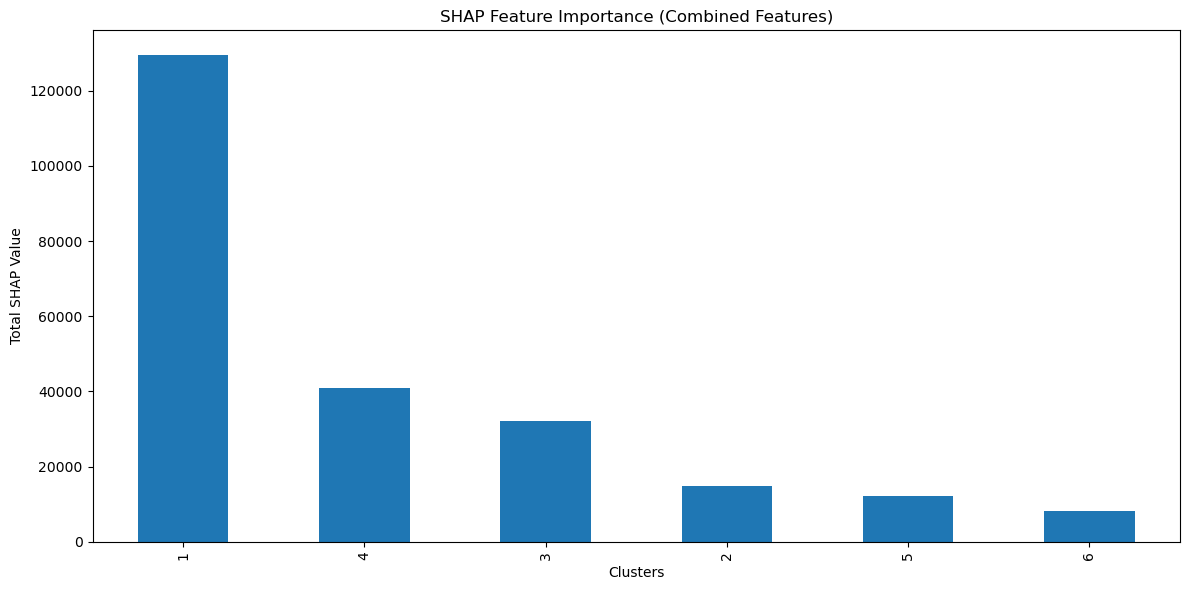

In [87]:
import pandas as pd

# Start with your original clusters and global_shap_values

# Initialize an empty DataFrame to store the SHAP values
shap_values_df = pd.DataFrame(columns = X_test_with_confounder.columns)

# Loop through each unique cluster
for i, cluster_i in enumerate(np.unique(clusters)):
    # Find the features in the current cluster
    features_i = np.where(clusters == cluster_i)[0]

    # Compute the mean SHAP value for each feature in the current cluster
    for feature in features_i:
        shap_values_df[X_test_with_confounder.columns[feature]] =global_shap_values[:, feature]

print(shap_values_df)
print(clusters)
shap_values_df=np.sum(shap_values_df, axis=0)
print(shap_values_df)
cluster_shap_sums = shap_values_df.groupby(clusters)
print(cluster_shap_sums)
# Sort the clusters by their total SHAP values
sorted_cluster_shap_sums = cluster_shap_sums.sum().sort_values(ascending=False)
# Transpose the DataFrame
sorted_cluster_shap_sums = sorted_cluster_shap_sums.transpose()
# Plot the SHAP values as a stacked bar chart
sorted_cluster_shap_sums.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('SHAP Feature Importance (Combined Features)')
plt.xlabel('Clusters')
plt.ylabel('Total SHAP Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
cluster_shap_sums